In [179]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.__version__)  # Check the installed PyTorch version
print(torch.version.cuda)  # Check CUDA version used by PyTorch

z = 1
dpival = 2000
cmapname = "summer"
font = {'family': 'serif', 'serif': ['Computer Modern']}
line = {'linewidth': 2/z, 'linestyle' : 'solid'}
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', **font)  # pass in the font dict as kwargs
matplotlib.rc('font', weight='bold')  # pass in the font dict as kwargs
matplotlib.rc('lines', **line)
matplotlib.rc('axes', labelsize=20/z, labelweight = 'bold')
matplotlib.rc('legend', fontsize=15/z, frameon=False)
matplotlib.rc('xtick.major', size=2/z)
matplotlib.rc('ytick.major', size=2/z)
matplotlib.rc('xtick', labelsize=20/z, direction='in')
matplotlib.rc('ytick', labelsize=20/z, direction='in')

True
2.4.1
12.4


In [180]:
def sampling_combined_model_passive(N, score_model, dt, tsteps, d=2):
    x = torch.randn(N,d).to(device)
    #samples = [x.detach()];
    for t in range(tsteps-2, 0, -1):
        #print(t)
        #xin = torch.cat((x, (t*dt) * torch.ones(x.shape[0], 1)), dim=1)
        tdt = dt*torch.ones(x.shape[0]).to(device)
        #print(tdt.device)
        with torch.no_grad():
            F = score_model(x, tdt);
        var_t = (1 - torch.exp(-2 * tdt))
        x = x + x*dt + 2*F*dt + np.sqrt(2*dt)*torch.randn(N,d).to(device)                           # If using the total score function
        #samples.append(x.detach())
    return x.detach()

def sampling_combined_model_active(N, score_model_eta, Tp, Ta, tau, k, dt, tsteps, initial_x_value=0.0, initial_eta_value=0.0, device="cuda", d=2):
    x_trajectories = []  # Initialize a list to store trajectories
    #x = torch.ones(N, 2, device=device) * initial_x_value
    #eta = torch.ones(N, 2, device=device) * initial_eta_value
    var11 = Tp / k + (Ta / (k * k * tau + k))
    var12 = Ta / (1 + tau * k)
    var22 = Ta / tau
    base_cov = torch.tensor([[var11, var12], [var12, var22]], device=device, dtype=torch.float32)
    
    # Cholesky decomposition of the 2×2 covariance matrix
    L = torch.linalg.cholesky(base_cov)  # Cholesky factorization
    
    # Generate `N` samples for `d` independent (x, eta) pairs
    x_list, eta_list = [], []
    for _ in range(d):
        uncorrelated_samples = torch.randn(N, d, device=device)  # (N, 2)
        correlated_samples = uncorrelated_samples @ L.T  # Apply transformation
    
        x_list.append(correlated_samples[:, 0])  # First column = x values
        eta_list.append(correlated_samples[:, 1])  # Second column = eta values
    
    # Stack the results into (N, d) matrices
    x = torch.stack(x_list, dim=1)  # Shape (N, d)
    eta = torch.stack(eta_list, dim=1)  # Shape (N, d)
    
    for t in range(tsteps - 2, 0, -1):
        t_tensor = (t * dt) * torch.ones((N, 1), device=device)
        xin = torch.cat((x, eta), dim=1)
        with torch.no_grad():
            #Fx = score_model_x(xin, t_tensor)
            Feta = score_model_eta(xin, t_tensor)
        x = x + dt * (x - eta) + torch.sqrt(2 * Tp * dt) * torch.randn_like(x, device=device)
        eta = eta + (dt * eta / tau) + (2 * Ta / (tau * tau)) * Feta * dt + (1 / tau) * torch.sqrt(2 * Ta * dt) * torch.randn_like(eta, device=device)
        x_trajectories.append(x.detach().cpu().numpy())

    # Convert trajectories to a NumPy array
    x_trajectories = np.array(x_trajectories)

    # Plot the trajectories
    #for i in range(N):
    #    plt.plot(np.arange(tsteps - 2, 0, -1) * dt, x_trajectories[:, i, 0])  # Fix: Use correct range for time values

    #plt.xlabel("Time")
    #plt.ylabel("x")
    #plt.title("Diffusion Trajectories")
    #plt.show()

    return x.detach(), eta.detach()

In [181]:
class ResNet(nn.Module):
    def __init__(self, input_dim=2, index_dim=1, hidden_dim=64, out_dim=2, n_hidden_layers=20):
        super().__init__()
        self.act = nn.SiLU()
        self.n_hidden_layers = n_hidden_layers

        # Input dimension is input_dim plus time embedding dimension (index_dim)
        in_dim = input_dim + index_dim

        layers = []
        # First layer: from (input_dim + index_dim) to hidden_dim
        layers.append(nn.Linear(in_dim, hidden_dim))
        # Hidden layers: each layer takes hidden_dim concatenated with time (index_dim) and outputs hidden_dim
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_dim + index_dim, hidden_dim))
        # Final layer: from (hidden_dim + index_dim) to output dimension
        layers.append(nn.Linear(hidden_dim + index_dim, out_dim))
        
        self.layers = nn.ModuleList(layers)

    def _append_time(self, h, t):
        # Append the log of time to each feature vector
        time_embedding = torch.log(t).to(device)
        return torch.cat([h, time_embedding.reshape(-1, 1)], dim=1)

    def forward(self, u, t):
        # Initial layer: append time to input u and apply the first linear layer with activation
        h = self.act(self.layers[0](self._append_time(u, t)))
        # Process through hidden layers with residual connections
        for i in range(self.n_hidden_layers):
            h_new = self.layers[i + 1](self._append_time(h, t))
            h = self.act(h + h_new)
        # Final layer: append time and compute output
        return self.layers[-1](self._append_time(h, t))

# Create an instance of the ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [182]:
d = 2
model_pas = ResNet(input_dim=d, index_dim=1, hidden_dim=64, out_dim=d, n_hidden_layers=20)
model_act = ResNet(input_dim=2*d, index_dim=1, hidden_dim=64, out_dim=d, n_hidden_layers=20)
model_pas = model_pas.to(device)
model_act = model_act.to(device)

In [183]:
epoch = 9999
T = 1.0
Ta = 1.0
tau = 0.5
num_components = "spiral"
checkpoint_pas = torch.load('Passive_models_{}_T_{}/model_at_epoch_{}.pth'.format(num_components, T, epoch), weights_only=True)
model_pas.load_state_dict(checkpoint_pas['model_state_dict'])
checkpoint_act = torch.load('Active_models_{}_Ta_{}_tau_{}/model_at_epoch_{}.pth'.format(num_components, Ta, tau, epoch), weights_only=True)
model_act.load_state_dict(checkpoint_act['model_state_dict'])

<All keys matched successfully>

In [184]:
dt = 0.01
tsteps = 200
T = torch.tensor(1.0, device=device)
Tp = torch.tensor(1e-3, device=device)
Ta = torch.tensor(1.0, device=device)
tau = torch.tensor(0.5, device=device)
final_data_pas = sampling_combined_model_passive(8000, model_pas, dt, tsteps)
final_data_act = sampling_combined_model_active(8000, model_act, Tp, Ta, tau, 1.0, dt, tsteps, device="cuda")

In [185]:
pas_data = final_data_pas.cpu().numpy()
act_data = final_data_act[0].cpu().numpy()

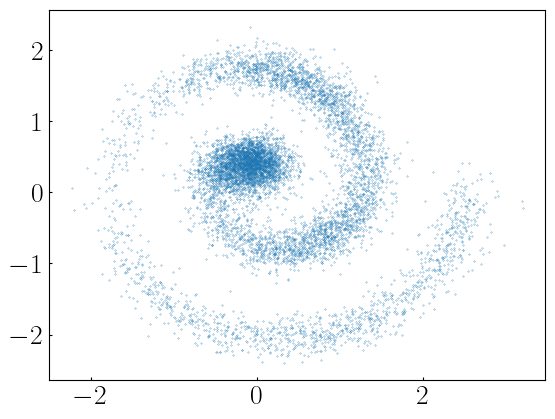

In [186]:
plt.scatter(pas_data[:,0], pas_data[:,1], s = 0.05)

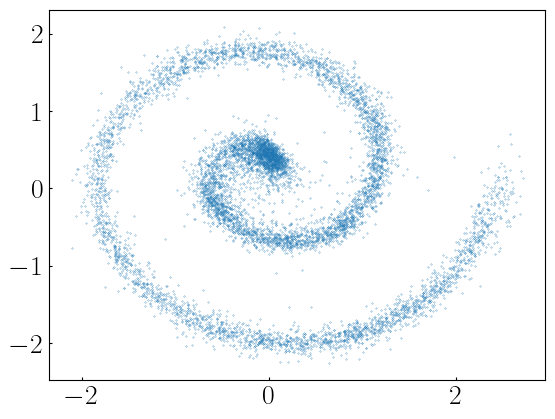

In [187]:
plt.scatter(act_data[:,0], act_data[:,1], s=0.05)